<a href="https://www.kaggle.com/code/kevinnkansah/formula-1-inceptionv3-keras?scriptVersionId=184277166" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread
import plotly.express as px
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    BatchNormalization,
    Dropout,
    Dense,
    Flatten,
)
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import warnings

pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")

2024-06-19 00:03:11.164021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 00:03:11.164132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 00:03:11.296795: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of devices: 2


In [2]:
ALPHA = '/kaggle/input/formula-1-car-classification-dataset/AlphaTauri F1 car'
FERRARI = '/kaggle/input/formula-1-car-classification-dataset/Ferrari F1 car'
MCLAREN = '/kaggle/input/formula-1-car-classification-dataset/McLaren F1 car'
MERCEDES = '/kaggle/input/formula-1-car-classification-dataset/Mercedes F1 car'
RACING_POINT = '/kaggle/input/formula-1-car-classification-dataset/Racing Point F1 car'
REDBULL = '/kaggle/input/formula-1-car-classification-dataset/Red Bull Racing F1 car'
RENAULT = '/kaggle/input/formula-1-car-classification-dataset/Renault F1 car'
WILLIAMS = '/kaggle/input/formula-1-car-classification-dataset/Williams F1 car'

file_paths = ([os.path.join(ALPHA, f) for f in os.listdir(ALPHA)]
+ [os.path.join(FERRARI, f) for f in os.listdir(FERRARI)]
+ [os.path.join(MCLAREN, f) for f in os.listdir(MCLAREN)]
+ [os.path.join(MERCEDES, f) for f in os.listdir(MERCEDES)]
+ [os.path.join(RACING_POINT, f) for f in os.listdir(RACING_POINT)]
+ [os.path.join(REDBULL, f) for f in os.listdir(REDBULL)]
+ [os.path.join(RENAULT, f) for f in os.listdir(RENAULT)]
+ [os.path.join(WILLIAMS, f) for f in os.listdir(WILLIAMS)])

labels = (['AlphaTauri F1 car'] * len(os.listdir(ALPHA))
          +['Ferrari F1 car'] * len(os.listdir(FERRARI))
          +['McLaren F1 car'] * len(os.listdir(MCLAREN))
          +['Mercedes F1 car'] * len(os.listdir(MERCEDES))
          +['Racing Point F1 car'] * len(os.listdir(RACING_POINT))
          +['Red Bull Racing F1 car'] * len(os.listdir(REDBULL))
          +['Renault F1 car'] * len(os.listdir(RENAULT))
          +['Williams F1 car'] * len(os.listdir(WILLIAMS)))

df = pd.DataFrame.from_dict({'file_paths' : file_paths, 'labels' : labels})
df = df.sample(frac=1)

## Data Visualization

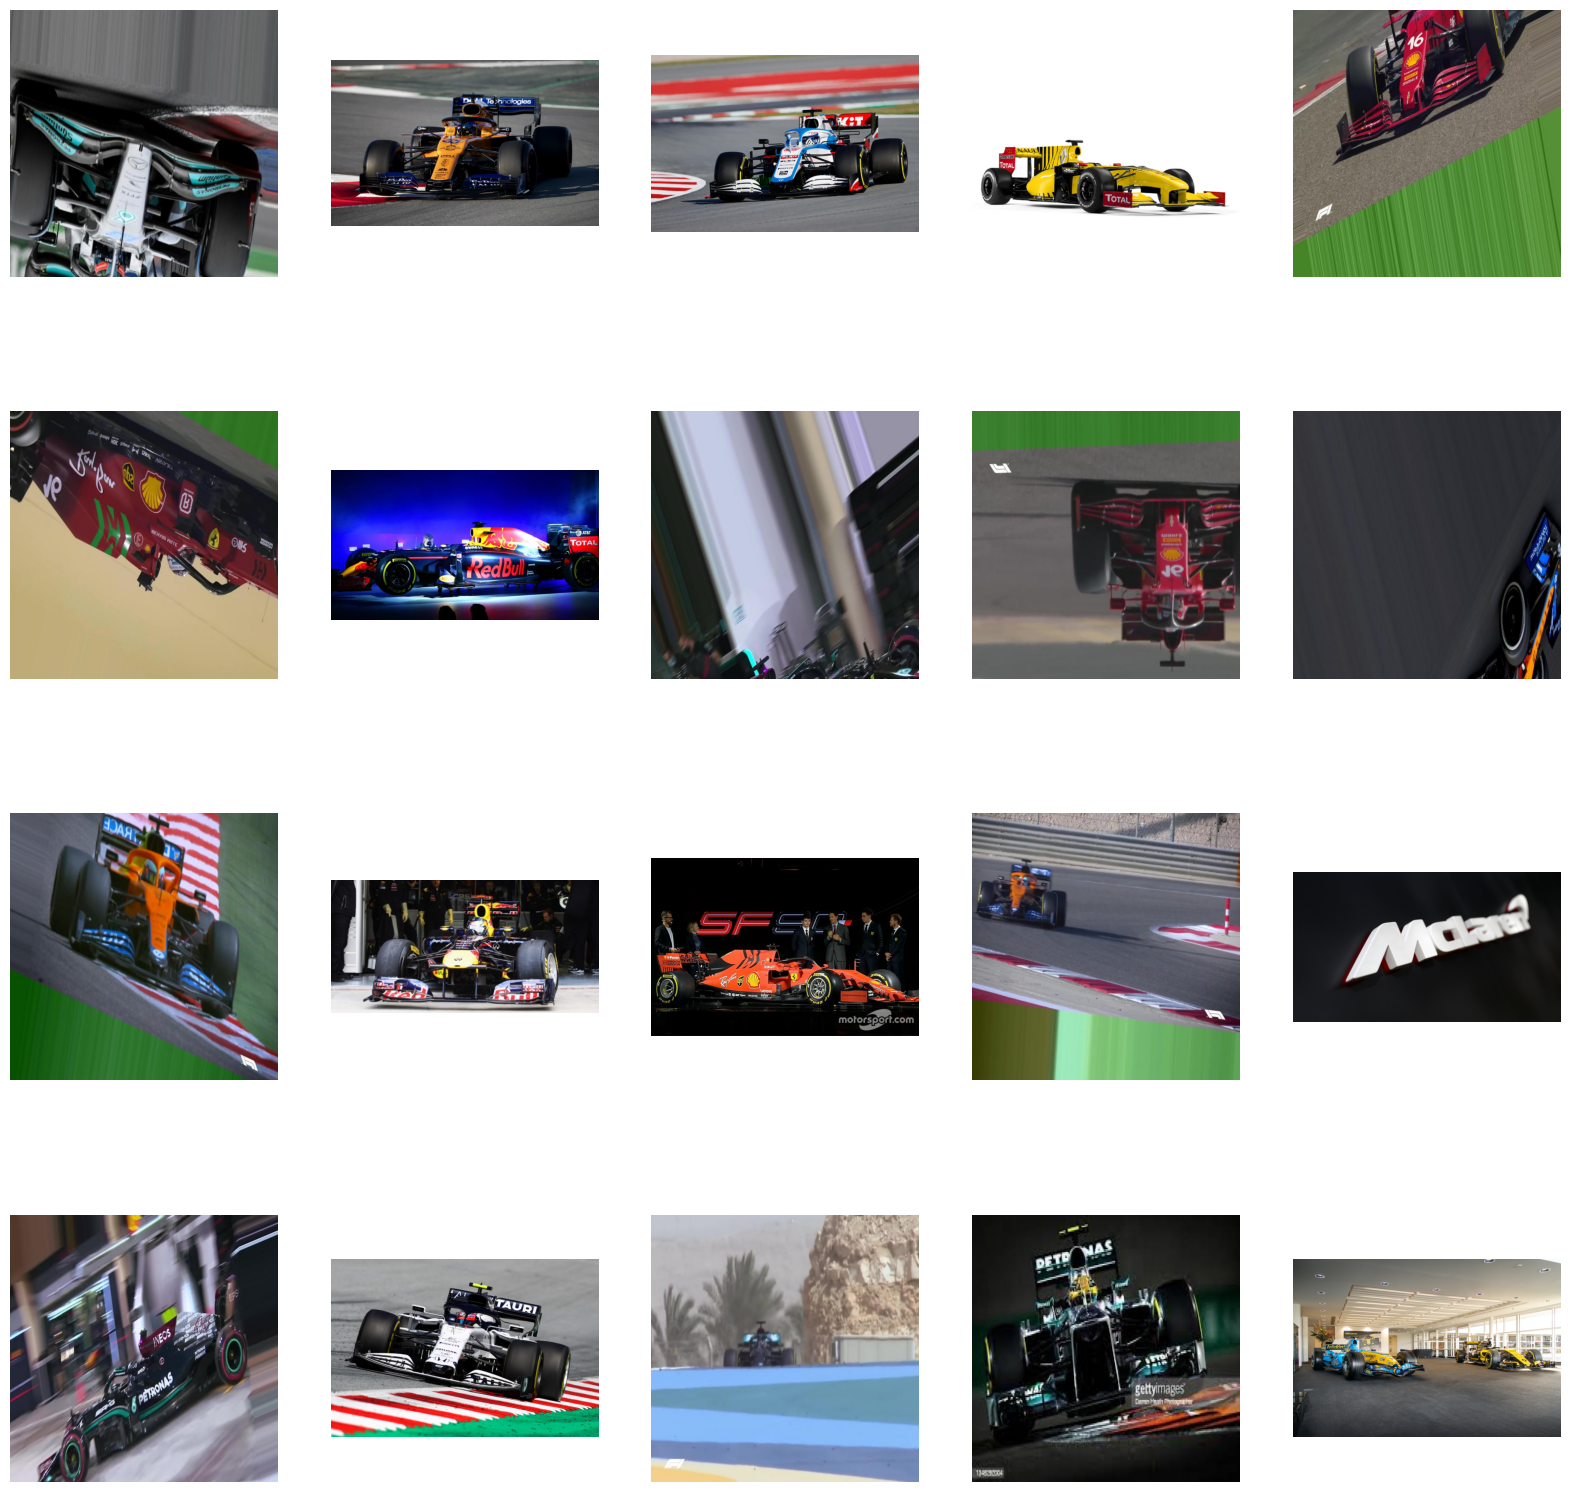

In [3]:
fig, ax = plt.subplots(4, 5, figsize=(20, 20))
ax = ax.flatten()
for idx, file in enumerate(df['file_paths']):
    try:
        image = imread(file)
        ax[idx].imshow(image)
        ax[idx].axis('off')
    except IndexError:
        break

plt.show()

In [4]:
px.pie(data_frame=df, names='labels')

## Data Preprocessing

In [5]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['labels'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels'], random_state=42)

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_data = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="file_paths",
    y_col="labels",
    target_size=(299, 299),
    shuffle=True,
)

val_data = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="file_paths",
    y_col="labels",
    target_size=(299, 299),
    shuffle=False,
)

test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="file_paths",
    y_col="labels",
    target_size=(299, 299),
    shuffle=False,
)

Found 3539 validated image filenames belonging to 8 classes.
Found 760 validated image filenames belonging to 8 classes.
Found 764 validated image filenames belonging to 8 classes.


## Model Training (Transfer Learning with InceptionV3)

In [8]:
with strategy.scope(): # for using both GPUs
    pretrained_model = InceptionV3(include_top=False,
                             weights="imagenet",
                             input_shape=(299, 299, 3))
    
    pretrained_model.trainable = False
    
    inputs = Input(shape=(299, 299, 3))
    x = pretrained_model(inputs, training=False)
    
    x = Conv2D(128, (3, 3), activation='swish')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(256, (3, 3), activation='swish')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='swish')(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(8, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 6, 6, 128)      │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 1, 1, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,596,648 (93.83 MB)

 Trainable params: 2,792,072 (10.65 MB)

 Non-trainable params: 21,804,576 (83.18 MB)

In [9]:
epochs = 60
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=4)

history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/60
111/111 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.2949 - loss: 2.3154 - val_accuracy: 0.2158 - val_loss: 3.6293 - learning_rate: 0.0010
Epoch 2/60
111/111 ━━━━━━━━━━━━━━━━━━━━ 115s 976ms/step - accuracy: 0.4451 - loss: 1.7132 - val_accuracy: 0.4868 - val_loss: 1.7373 - learning_rate: 0.0010
Epoch 3/60
111/111 ━━━━━━━━━━━━━━━━━━━━ 114s 964ms/step - accuracy: 0.5215 - loss: 1.4120 - val_accuracy: 0.5421 - val_loss: 1.3555 - learning_rate: 0.0010
Epoch 4/60
111/111 ━━━━━━━━━━━━━━━━━━━━ 114s 968ms/step - accuracy: 0.5534 - loss: 1.3305 - val_accuracy: 0.5842 - val_loss: 1.2984 - learning_rate: 0.0010
Epoch 5/60
111/111 ━━━━━━━━━━━━━━━━━━━━ 116s 986ms/step - accuracy: 0.5749 - loss: 1.2453 - val_accuracy: 0.5684 - val_loss: 1.2143 - learning_rate: 0.0010
Epoch 6/60
111/111 ━━━━━━━━━━━━━━━━━━━━ 115s 973ms/step - accuracy: 0.5996 - loss: 1.1429 - val_accuracy: 0.6789 - val_loss: 1.0116 - learning_rate: 0.0010
Epoch 7/60
111/111 ━━━━━━━━━━━━━━━━━━━━ 113s 964ms/step - accuracy:

## Model Evaluation

In [10]:
loss, accuracy = model.evaluate(test_data)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 734ms/step - accuracy: 0.7802 - loss: 0.6382
Loss: 0.6470786333084106
Accuracy: 0.782722532749176


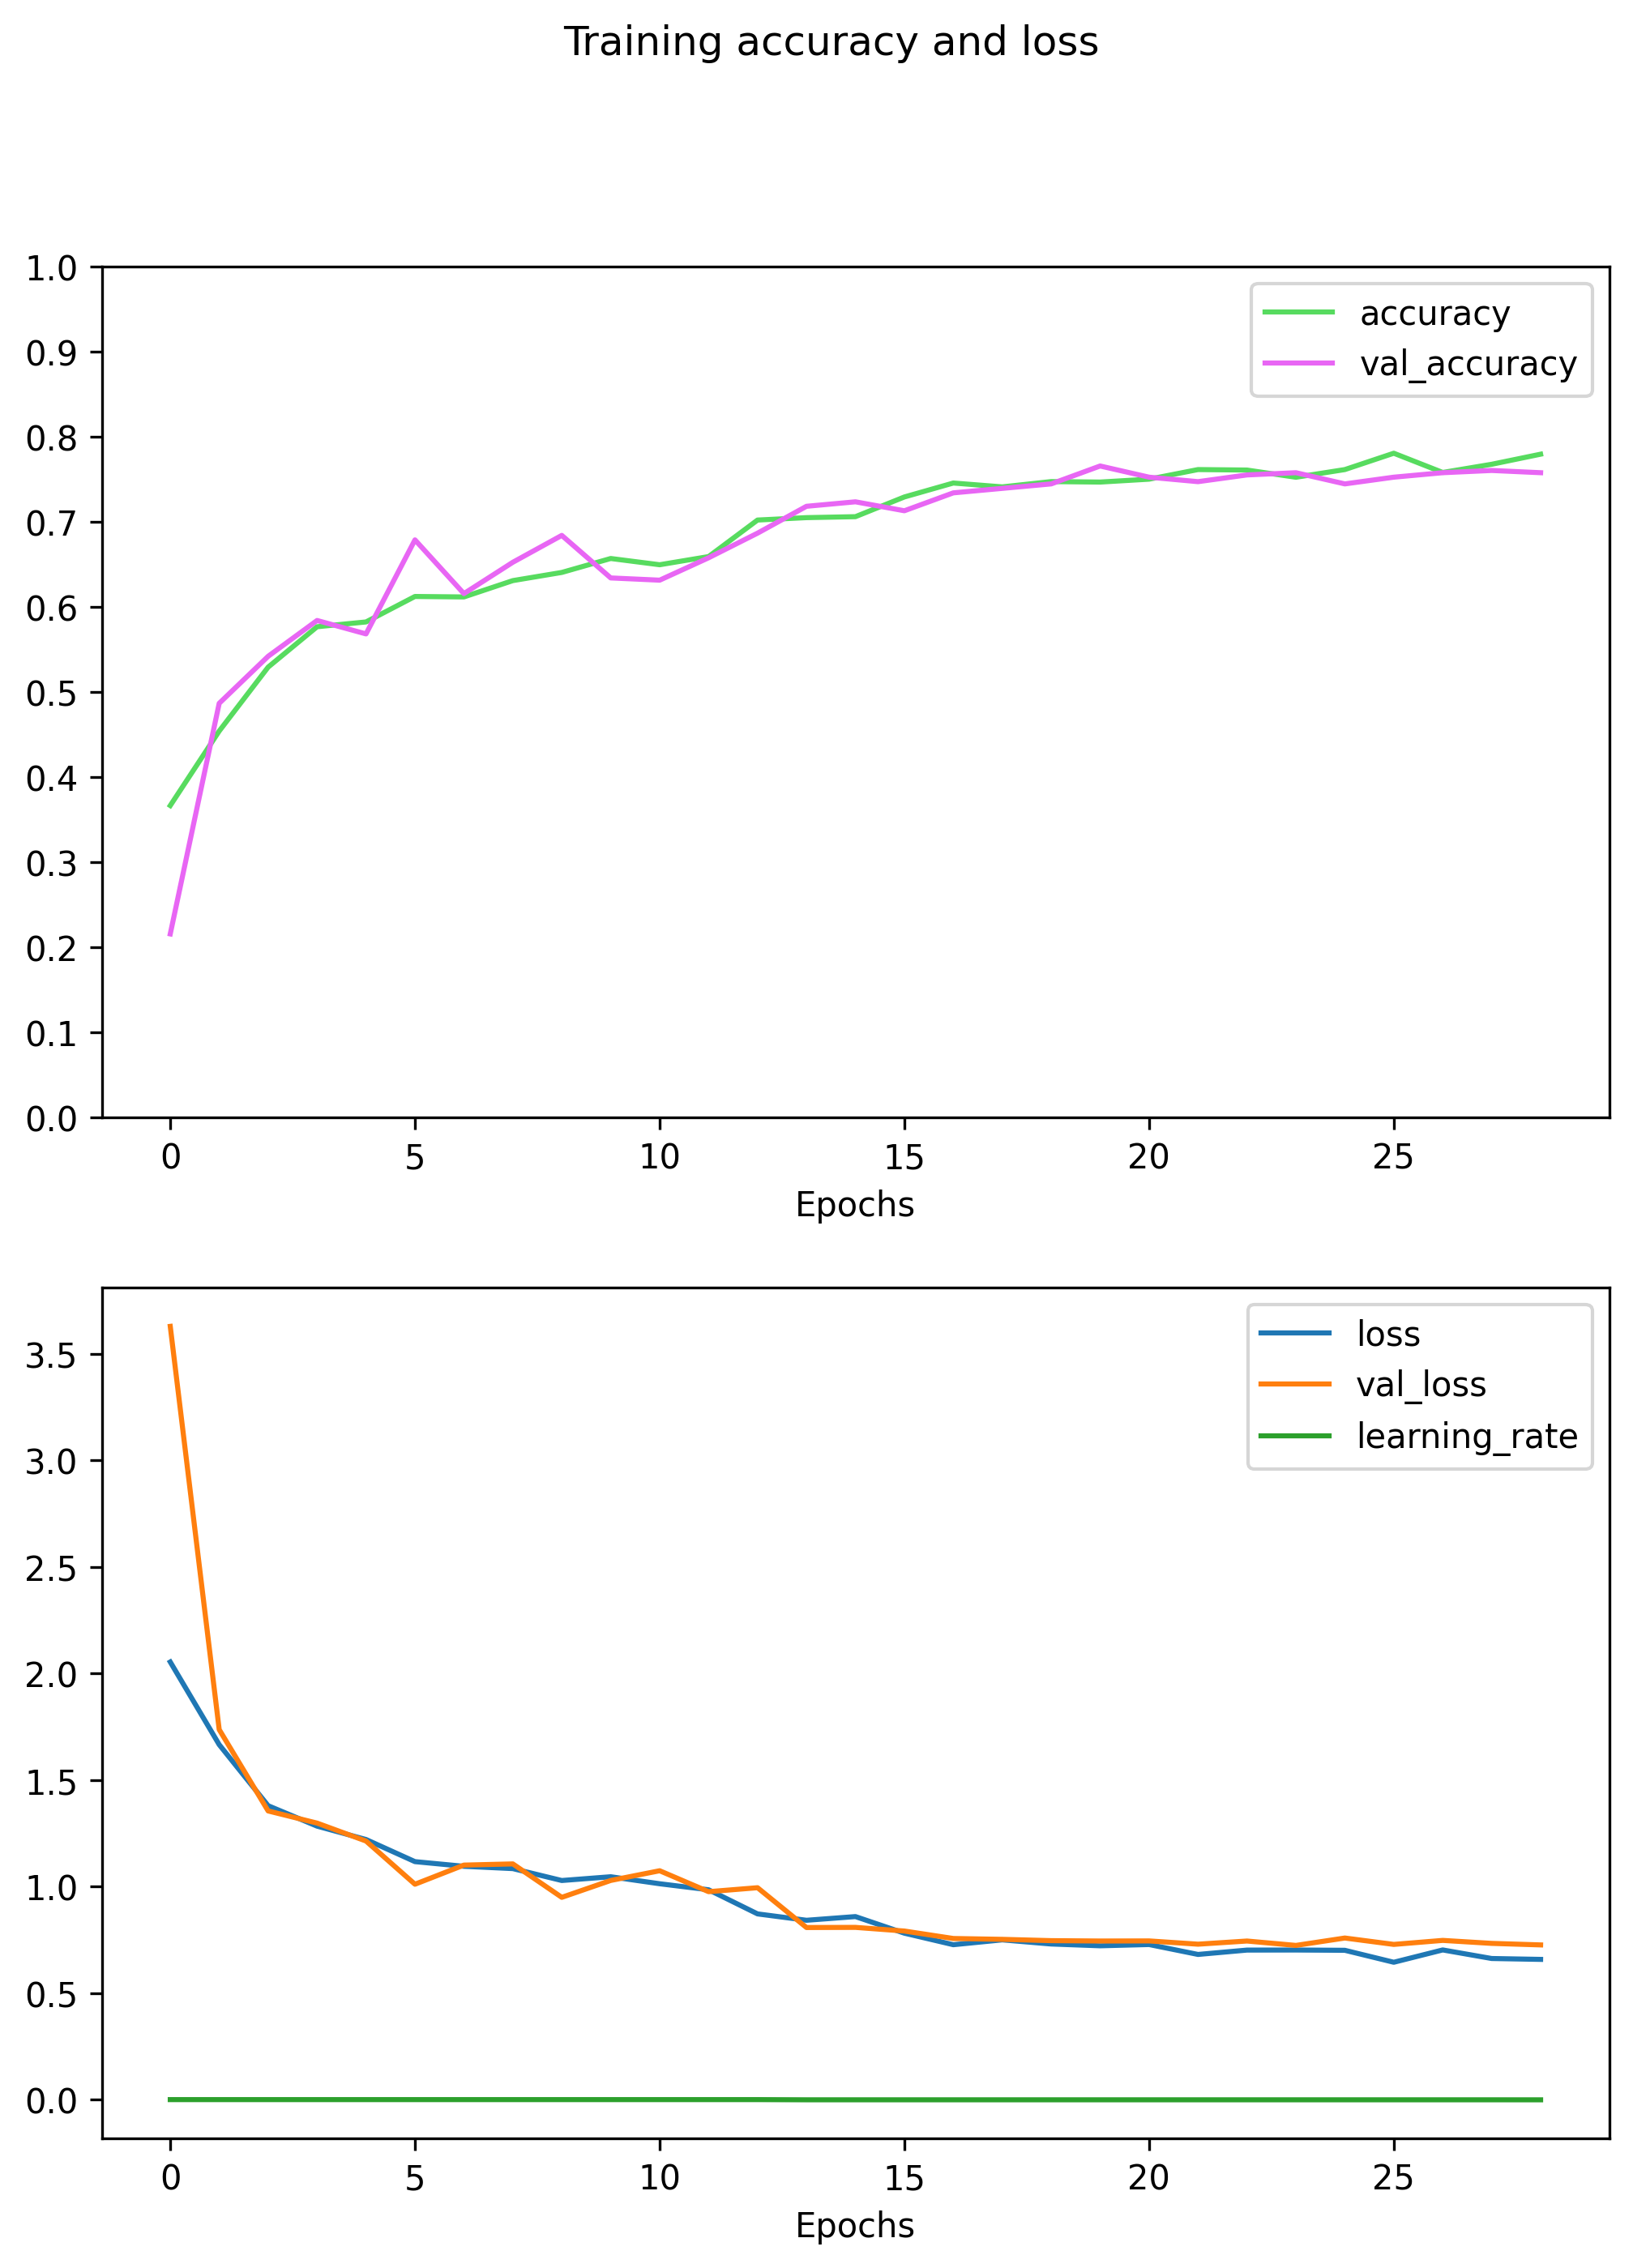

In [11]:
acc_loss_metrics = history.history

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), dpi=300)
plt.suptitle("Training accuracy and loss")
for lable, values in acc_loss_metrics.items():
    if lable == "accuracy":
        ax[0].plot(values, label=lable, color=sns.color_palette("hls")[2])
    elif lable == "val_accuracy":
        ax[0].plot(values, label=lable, color=sns.color_palette("husl")[5])
    else:
        ax[1].plot(values, label=lable)

ax[0].set_xlabel("Epochs")
ax[0].set_yticks(np.arange(0, 1.1, 0.1))
ax[0].legend()

ax[1].set_xlabel("Epochs")
ax[1].legend()
plt.show()

In [12]:
y_pred = model.predict(test_data)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test = test_data.classes

24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 492ms/step


In [13]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53        19
           1       0.83      0.86      0.85       131
           2       0.69      0.77      0.72       128
           3       0.88      0.71      0.79       222
           4       0.83      0.71      0.77        42
           5       0.74      0.86      0.80       125
           6       0.64      0.54      0.59        46
           7       0.65      0.82      0.72        51

    accuracy                           0.76       764
   macro avg       0.72      0.73      0.72       764
weighted avg       0.77      0.76      0.76       764



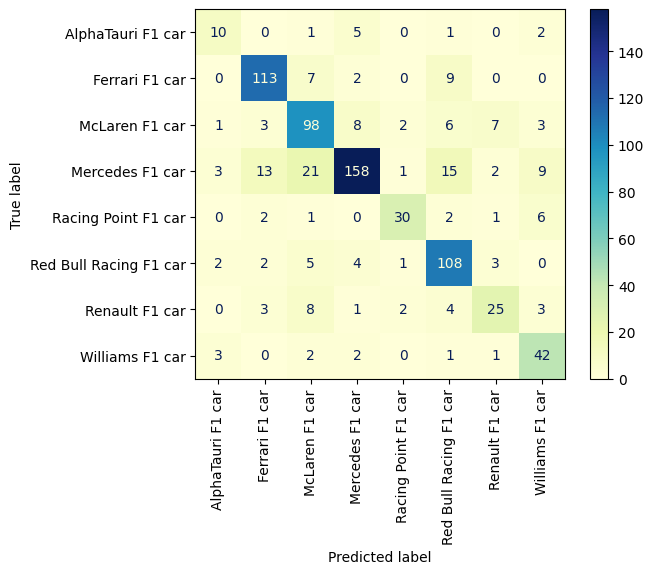

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_labels, cmap='YlGnBu', display_labels=list(test_data.class_indices.keys()))
plt.xticks(rotation=90)
plt.show()
